In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours

import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def excise_segmentation(image):
    
    resized = imutils.resize(image, height=500)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray)
    # blurred = cv2.medianBlur(equ, 3)
    blurred = cv2.GaussianBlur(equ, (3, 3), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # return the segmentationed image
    return resized, equ, thresholded


def appendROICnts(
    ROISizedCnts, 
    baseIndex, 
    ROICnts, 
    UsedROICandidate, 
    groupCount, 
    iterations, 
    x, y, w, h, 
    dimension,
    image,
    colors):

    ROICntsCandidate = []
    compareIndex = 0
    for compC in ROISizedCnts:
        # already used
        if (compareIndex in UsedROICandidate):
            compareIndex += 1
            continue

        iterations += 1
        (cx, cy, cw, ch) = cv2.boundingRect(compC)
        # Contours are close and same enought
        if (((abs(x - cx) < 15) and (abs((x + w) - (cx + cw)) < 15) and (abs(w - cw) < 15) and (dimension == 'x')) or 
           ((abs(y - cy) < 15) and (abs((y + h) - (cy + ch)) < 15) and (abs(h - ch) < 15) and (dimension == 'y'))):
            ROICntsCandidate.append(compareIndex)
        
        compareIndex += 1
    
    if (len(ROICntsCandidate) > 8):  # 9 digits
        groupROICnts = []
        for index in ROICntsCandidate:  # add to ROI
            iterations += 1
            groupROICnts.append(ROISizedCnts[index])
            (x2, y2, w2, h2) = cv2.boundingRect(ROISizedCnts[index])
            cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), colors[groupCount], 2)
            if (index != baseIndex):
                UsedROICandidate.append(index)  # remove trash from base array
            else:
                if (dimension == 'y'):
                    UsedROICandidate.append(index)
        groupCount += 1
        if (dimension == 'x'):
            ROICnts.append({ 'orientation': 'vertical', 'contours': contours.sort_contours(groupROICnts, method="bottom-to-top")[0] })
        if (dimension == 'y'):
            ROICnts.append({ 'orientation': 'horisontal', 'contours': contours.sort_contours(groupROICnts, method="left-to-right")[0] })
                    
    return ROICnts, UsedROICandidate, groupCount, iterations, image


def select_contours(thresholded):
    
    refCnts = cv2.findContours(cv2.Canny(thresholded, 30, 200).copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    
    width, height = thresholded.shape[:2]
    clone = np.dstack([thresholded.copy()] * 3)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    
    ROISizedCnts = []
    ROICnts = []
    iterations = 0

    # size filter
    for c in refCnts:
        iterations += 1
        (x, y, w, h) = cv2.boundingRect(c)
        if ((w < width / 9) and (h < height / 9 ) and (w > 7) and (h > 7)):  # 9 digits in serial must be on image
            ROISizedCnts.append(c)

    # positionin filter
    UsedROICandidate = []
    baseIndex = 0
    groupCount = 0
    for c in ROISizedCnts:  
        # already used
        if (baseIndex in UsedROICandidate): 
            baseIndex += 1
            continue

        iterations += 1       
        (x, y, w, h) = cv2.boundingRect(c)   

        # Compare for x dimension
        ROICnts, UsedROICandidate, groupCount, iterations, clone = appendROICnts(
            ROISizedCnts, 
            baseIndex, 
            ROICnts, 
            UsedROICandidate, 
            groupCount, 
            iterations, 
            x, y, w, h, 'x',
            clone,
            colors
        )

        # Compare for y dimension
        ROICnts, UsedROICandidate, groupCount, iterations, clone = appendROICnts(
            ROISizedCnts, 
            baseIndex, 
            ROICnts, 
            UsedROICandidate, 
            groupCount, 
            iterations, 
            x, y, w, h, 'y',
            clone,
            colors
        )

        baseIndex += 1
        
    return clone, ROICnts
    

CPU times: user 43.2 ms, sys: 0 ns, total: 43.2 ms
Wall time: 25.4 ms
CPU times: user 2.32 ms, sys: 0 ns, total: 2.32 ms
Wall time: 2.1 ms


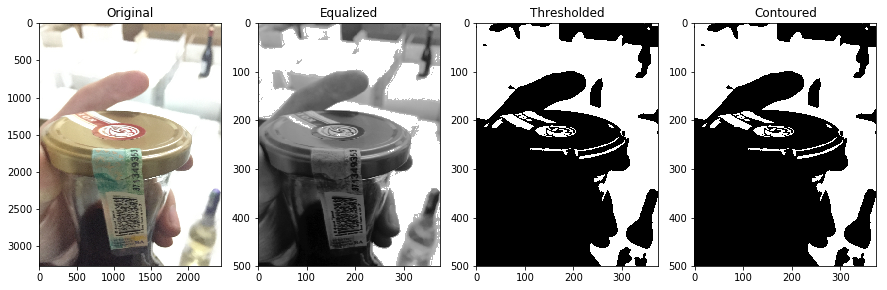

In [4]:
excise_src = cv2.imread("test_data/IMG_0216.JPG")
%time resized, equ, thresholded = excise_segmentation(excise_src)
%time contoured, ROICnts = select_contours(thresholded)

fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1,4,1)
imgplot = plt.imshow(cv2.cvtColor(excise_src, cv2.COLOR_BGR2RGB))
a.set_title('Original')

a = fig.add_subplot(1,4,2)
imgplot = plt.imshow(cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB))
a.set_title('Equalized')

a = fig.add_subplot(1,4,3)
imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
a.set_title('Thresholded')

a = fig.add_subplot(1,4,4)
imgplot = plt.imshow(cv2.cvtColor(contoured, cv2.COLOR_BGR2RGB))
a.set_title('Contoured')

plt.show()

### This problem will be solved by segmentation on frontend

In [8]:
def char_segmentation(input_src, fig, row_num, row_count):
    resized = imutils.resize(input_src, height=500)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray)
    # blurred = cv2.medianBlur(equ, 3)
    blurred = cv2.GaussianBlur(equ, (3, 3), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    a = fig.add_subplot(row_count, 3, 3 * row_num + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(row_count, 3, 3 * row_num + 2)
    imgplot = plt.imshow(cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB))
    a.set_title('Equalized')

    a = fig.add_subplot(row_count, 3, 3 * row_num + 3)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')

100%|██████████| 16/16 [00:10<00:00,  1.37it/s]


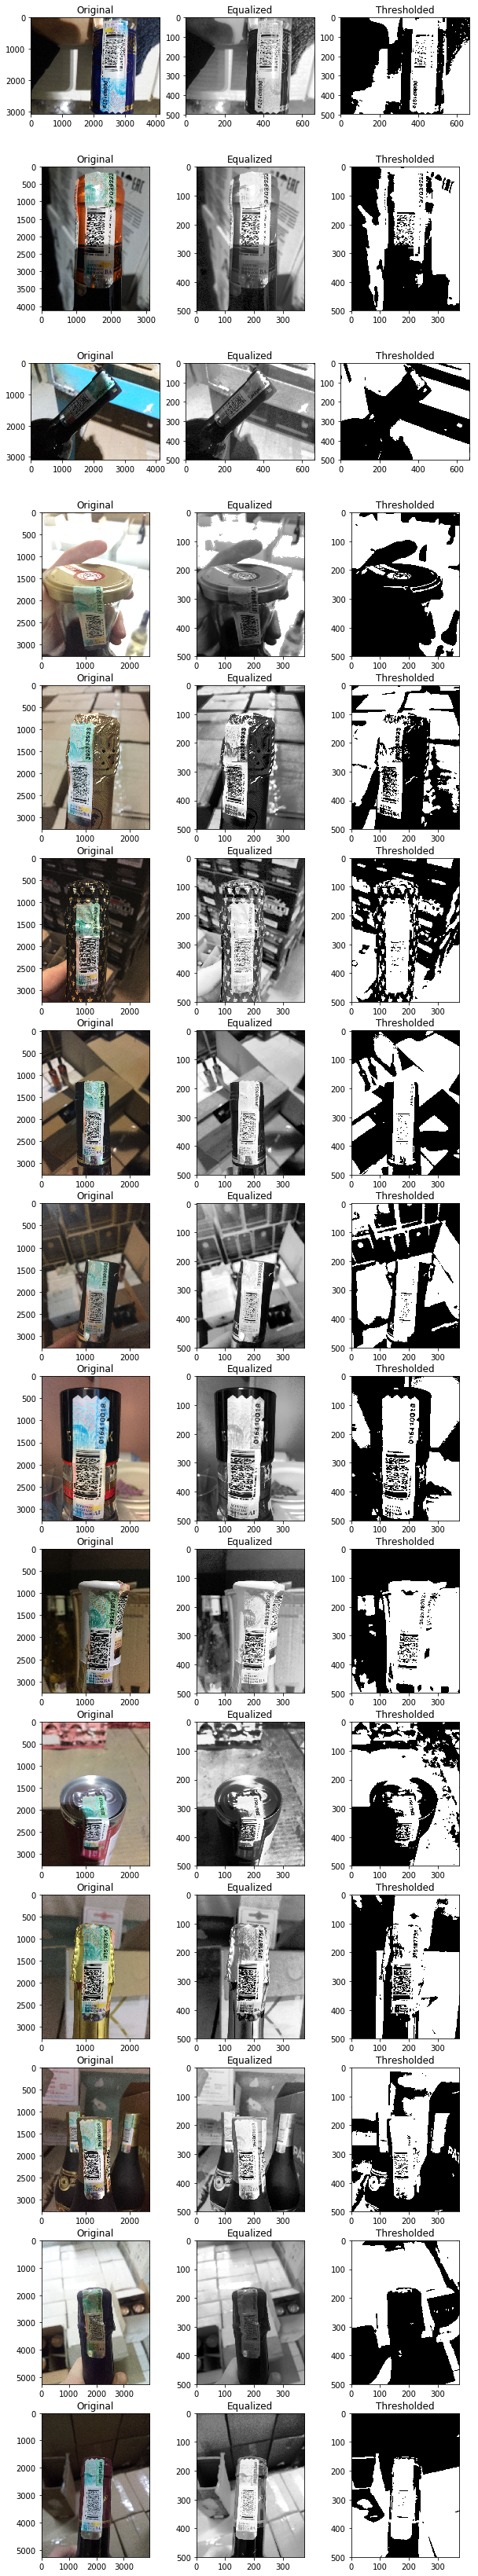

In [18]:
DIR = 'test_data'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".JPG") or name.endswith(".jpg"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 60))

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".JPG") or filename.endswith(".jpg")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))
    char_segmentation(file_src, fig, current_file_index, filescount)
    current_file_index += 1
    
plt.show()